## Preliminary

In [1]:
# Code to enable this notebook to import from libraries
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scripts.cavi_plot_utilities import *
from scripts.cavi import *
import copy
from scripts.cavi_utilities import *
from scripts.cavi_evaluation import *
from scripts.utilities import *

In [4]:
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [5]:
# Seed random state (for reproducibility)
np.random.seed(100)

## Data Simulation Settings

In [6]:
# Simulation settings
n_factors = 2
n_resolutions = 3
n_features = 400
n_spots = 256
L_shape = get_L_shape(n_spots, n_resolutions, n_factors)
Y_shape = get_Y_shape(n_spots, n_resolutions, n_features)
p_pi_shape = (n_resolutions,)
p_eta_shape = (n_factors,)
ab_t_shape = (n_resolutions, n_factors)
ab_tau_shape = (n_resolutions, n_features)
F_shape = (n_factors, n_features)

dimensions = {
    "n_factors" : n_factors,
    "n_resolutions" : n_resolutions,
    "n_features" : n_features,
    "n_spots" : n_spots,
    "L_shape" : L_shape,
    "Y_shape" : Y_shape,
    "p_pi_shape" : p_pi_shape,
    "p_eta_shape" : p_eta_shape,
    "ab_t_shape" : ab_t_shape,
    "ab_tau_shape" : ab_tau_shape,
    "F_shape" : F_shape
}

assert n_spots >= 4 ** (n_resolutions - 1)
assert is_power_of_4(n_spots)

In [17]:
# Run simulation for different signal to noise ratio values
from sklearn.preprocessing import StandardScaler

signal_to_noise_ratio_list = (0.03,0.1,0.3,1,3)
rrmse_pca = []
rrmse_wavifm = []
for signal_to_noise_ratio in signal_to_noise_ratio_list:
    np.random.seed(100) # set seed again for reproducibility
    # Setting ground truths
    true_p_pi = (3/4,1/4,1/8)
    true_pi = L_shaped_pi_organised(true_p_pi, dimensions)
    true_t = np.full(ab_t_shape, 1.0)
    true_eta = np.array((
        [1.0]*200 + [0.0]*200,
        [0.0]*200 + [1.0]*200,
    ))
    true_L = L_rand_norm_from_t(true_t, true_pi, dimensions)
    true_F = F_rand_norm(true_eta, dimensions)
    noiseless_Y_variances = Y_variances(true_L, true_F, dimensions) # This is the signal metric corresponding to tau_i_l which is considered noise
    noiseless_Y_unnormalised = Y_noiseless(true_L, true_F, dimensions)
    true_tau = get_tau(signal_to_noise_ratio, noiseless_Y_variances) # Expected to yield some infinities if some variances are 0
    true_Y_unnormalised = Y_rand_norm_from_tau(true_L, true_F, true_tau, dimensions)
    assert len(true_p_pi) == n_resolutions
    assert true_eta.shape == F_shape
    assert true_F.shape == F_shape
    
    # Standardize data for a fairer comparison with PCA
    wavelet_indices = get_wavelet_indices(true_Y_unnormalised)
    flattened_data_2D = flatten_data_to_2D(true_Y_unnormalised)
    flattened_noiseless_Y = flatten_data_to_2D(noiseless_Y_unnormalised)
    normaliser = StandardScaler().fit(flattened_data_2D)
    true_Y_flattened = normaliser.transform(flattened_data_2D)
    
    # Standardise noiseless Y with the same transform as trained on the data with noise
    noiseless_Y_flattened = normaliser.transform(flattened_noiseless_Y)
    
    # Convert the standardised data to format suitable for WaviFM input
    true_Y = reshape_flattened_2D(true_Y_flattened.transpose(), wavelet_indices) 
    noiseless_Y = reshape_flattened_2D(noiseless_Y_flattened.transpose(), wavelet_indices) 
    
    # Run PCA
    wavelet_indices = get_wavelet_indices(true_Y)
    flattened_data_2D = flatten_data_to_2D(true_Y)

    pca = PCA(n_components=n_factors)
    flattened_L_pca = pca.fit_transform(flattened_data_2D).transpose()
    F_pca = pca.components_
    variance_ratio = pca.explained_variance_ratio_
    L_pca = reshape_flattened_2D(flattened_L_pca, wavelet_indices)
    
    # Run CAVI from WaviFM
    print(f"Running CAVI for SNR={signal_to_noise_ratio}")
    results = cavi_multi_init_cpp(
        true_Y,
        dimensions,
        max_iterations=1000,
        relative_elbo_threshold=0.0001,
        n_init=10
    )
    param_results = results["parameters"]
    
    # Computing posterior means for CAVI
    L_means = variational_approx_posterior_mean_L(param_results)
    F_means = variational_approx_posterior_mean_F(param_results)
    pi_means = variational_approx_posterior_mean_pi(param_results)
    eta_means = variational_approx_posterior_mean_eta(param_results)
    
    # Factor matching for CAVI
    factor_order_from_1 = (2,1)
    factor_order = [i-1 for i in factor_order_from_1]
    L_means = [L_means[i] for i in factor_order]
    pi_means = [pi_means[i] for i in factor_order]
    F_means = F_means[factor_order]
    eta_means = eta_means[factor_order]
    
    # Save results for SNR=0.3 for later use
    if signal_to_noise_ratio == 0.3:
        L_means_03 = L_means
        F_means_03 = F_means
        L_pca_03 = L_pca
        F_pca_03 = F_pca
        true_F_03 = true_F
        true_L_03 = true_L
    
    # Compute estimates for noiseless Y
    LF_pca = LF_product(L_pca, F_pca, dimensions)
    LF_means = LF_product(L_means, F_means, dimensions)
    
    # Compute and record RRMSE values
    rrmse_pca.append(rrmse(noiseless_Y, LF_pca))
    rrmse_wavifm.append(rrmse(noiseless_Y, LF_means))

Running CAVI for SNR=0.03
Initialisation 1:
	ELBO = -133907.682596615
	#Iterations = 10
	Time taken (s) = 0.22502994537353516
Initialisation 2:
	ELBO = -134057.15466249164
	#Iterations = 11
	Time taken (s) = 0.2509951591491699
Initialisation 3:
	ELBO = -134341.4697712918
	#Iterations = 7
	Time taken (s) = 0.17020463943481445
Initialisation 4:
	ELBO = -134343.99518440623
	#Iterations = 7
	Time taken (s) = 0.1644735336303711
Initialisation 5:
	ELBO = -133902.43785454065
	#Iterations = 10
	Time taken (s) = 0.22525405883789062
Initialisation 6:
	ELBO = -133900.05246028764
	#Iterations = 14
	Time taken (s) = 0.31799983978271484
Initialisation 7:
	ELBO = -133900.68895807076
	#Iterations = 13
	Time taken (s) = 0.30099940299987793
Initialisation 8:
	ELBO = -133907.21773921506
	#Iterations = 13
	Time taken (s) = 0.2909715175628662
Initialisation 9:
	ELBO = -134042.5685893388
	#Iterations = 24
	Time taken (s) = 0.5260300636291504
Initialisation 10:
	ELBO = -134770.12450903398
	#Iterations = 3
	T

## Analysis

In [18]:
# RRMSE values
rrmse_df = pd.DataFrame([rrmse_wavifm, rrmse_pca], index=["WaviFM", "PCA"], columns=signal_to_noise_ratio_list)
rrmse_df

,0.03,0.10,0.30,1.00,3.00
WaviFM,0.816671,0.346373,0.193422,0.104810,0.063561
PCA,1.063414,0.500036,0.274830,0.148407,0.085372


In [19]:
rb_centred_color_map = create_custom_colormap()

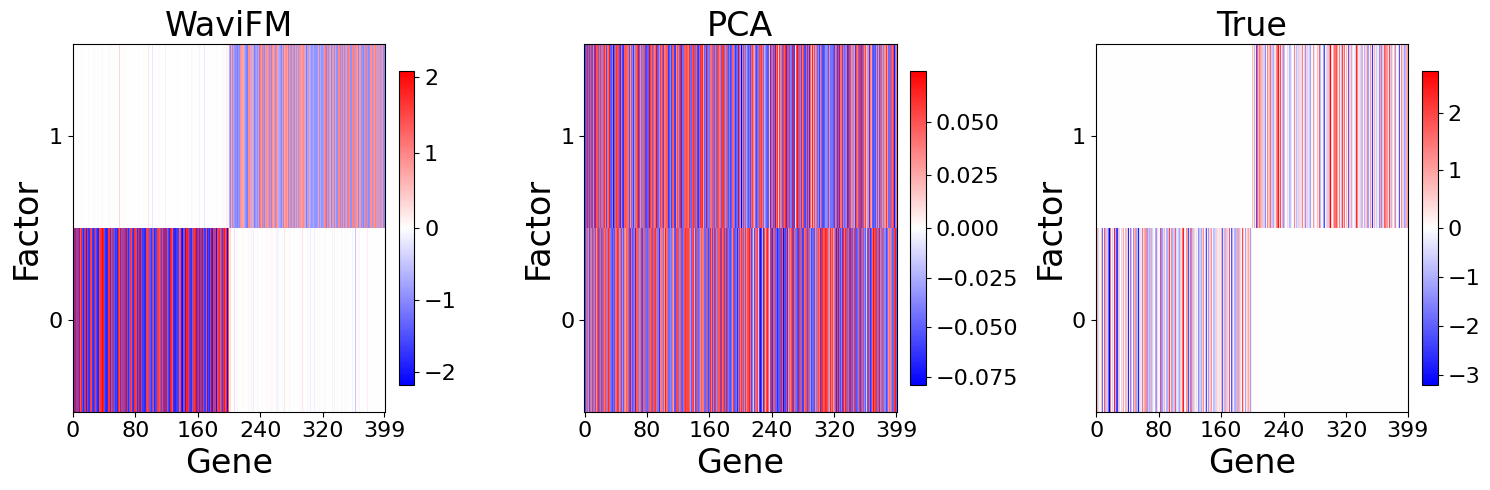

In [32]:
# Comparing F for SNR=0.3
plot_matrices_side_by_side(F_means_03, F_pca_03, true_F_03,
                           titles=["WaviFM", "PCA", "True"],
                           colormaps=[rb_centred_color_map, rb_centred_color_map, rb_centred_color_map],
                           x_labels=["Gene","Gene","Gene"],
                           y_labels=["Factor","Factor","Factor"],
                           aspect="auto",
                           x_ticks=np.append(np.arange(0,400,80), 399),
                           )

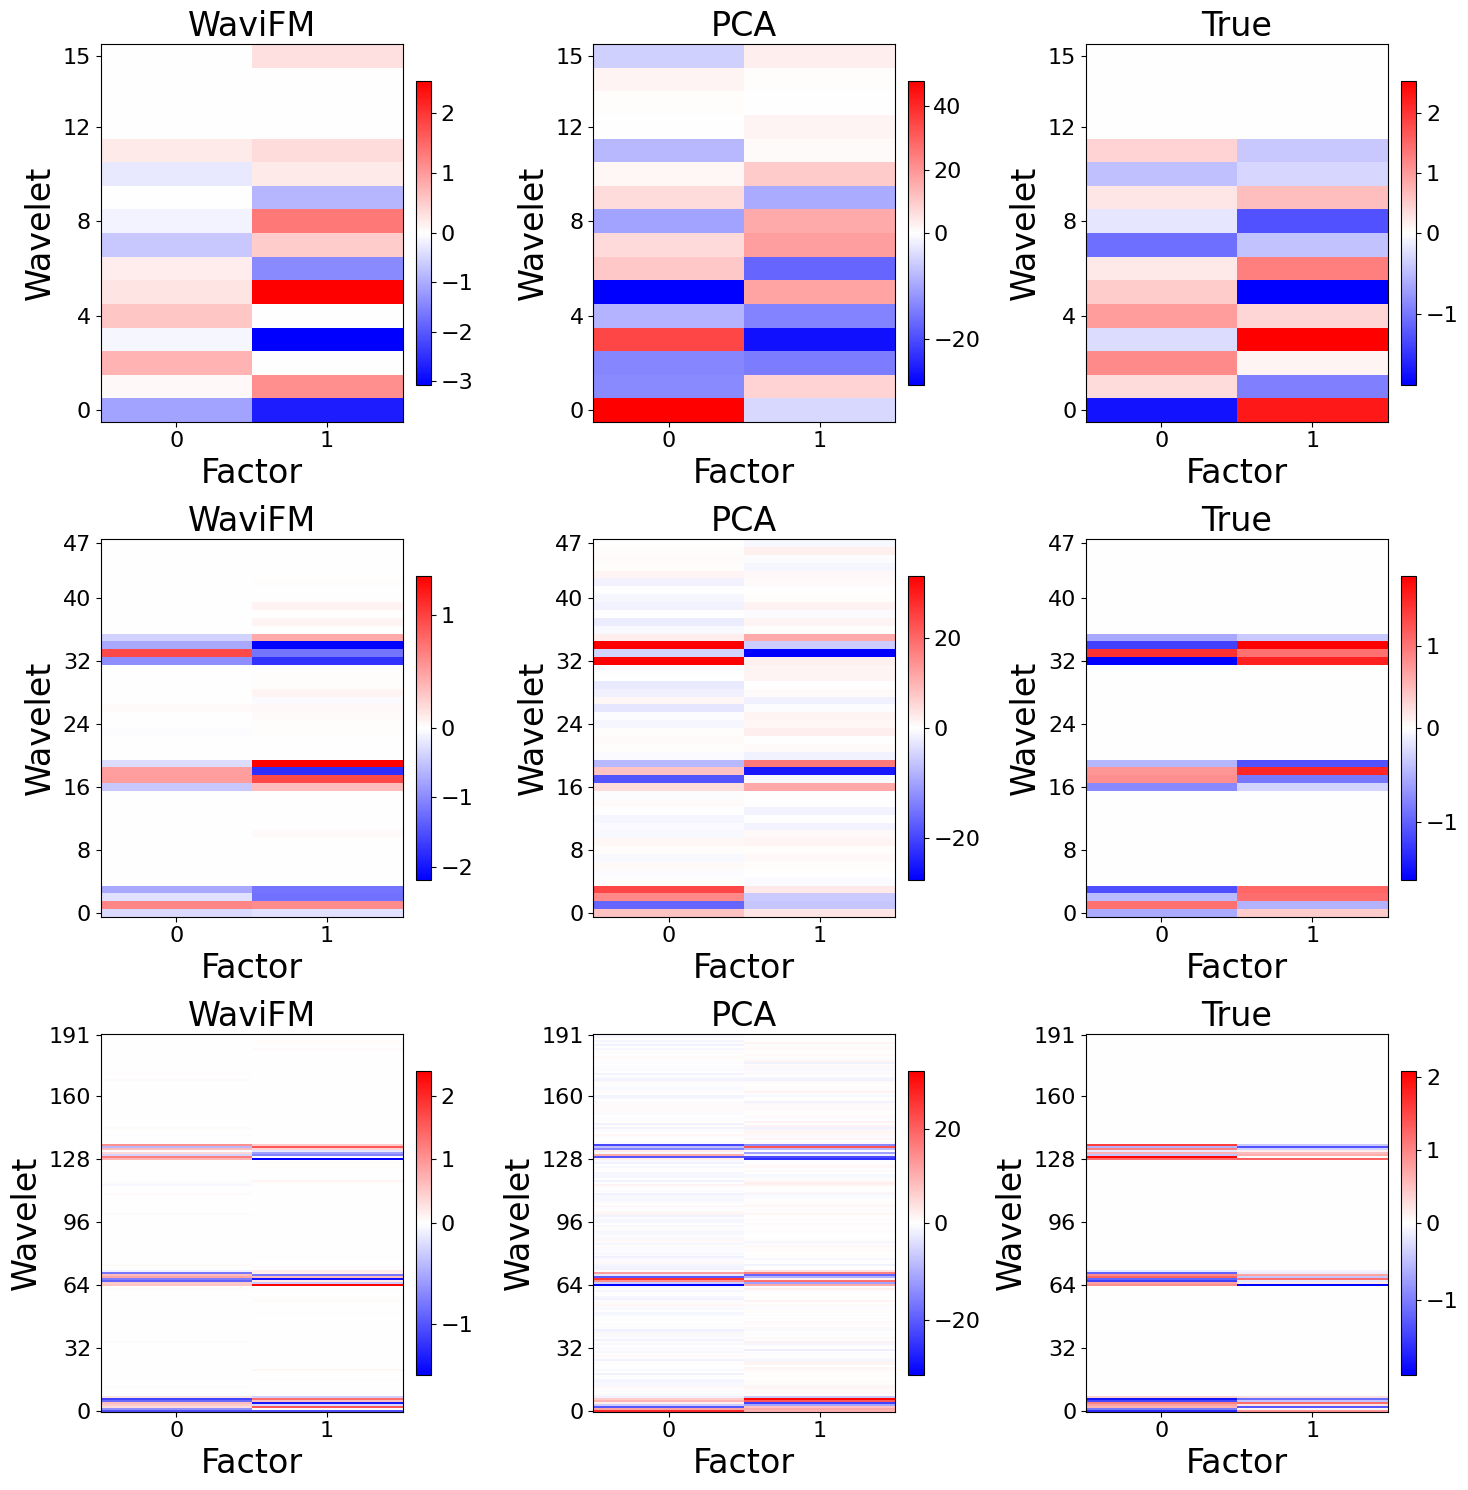

In [42]:
# Comparing L for SNR=0.3
resolution_tuples = generate_resolution_tuples(L_means_03, L_pca_03, true_L_03)
n_resolutions = len(resolution_tuples)
fig, axes = plt.subplots(n_resolutions, 3, figsize=(15, 5 * n_resolutions))
y_ticks_list = [np.append(np.arange(0,16,4), 15),
                np.append(np.arange(0,48,8), 47),
                np.append(np.arange(0,192,32), 191)]
for idx, (res_data1, res_data2, res_data3) in enumerate(resolution_tuples):
    plot_matrices_side_by_side(
        res_data1,
        res_data2,
        res_data3,
        titles=["WaviFM", "PCA", "True"],
        colormaps=[rb_centred_color_map, rb_centred_color_map, rb_centred_color_map],
        x_labels=["Factor","Factor","Factor"],
        y_labels=["Wavelet","Wavelet","Wavelet"],
        fig=fig,
        axes=axes[idx],
        aspect="auto",
        y_ticks=y_ticks_list[idx]
    )